<a href="https://colab.research.google.com/github/wallisonferreira/machine-learning-pavic/blob/main/pavic_09_pytorch_CV_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalhando com datasets customizados

## Importar bibliotecas

In [1]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu118'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1 Aquisição de dados

In [3]:
import requests
import zipfile
from pathlib import Path

In [4]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mafaldasalomao/pavic_treinamento_ml/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)

In [5]:
import os

def walk_dir(dir_path):
    '''
    percorre o diretório
    '''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"{len(dirnames)} pastas e {len(filenames)} imagens em [{dirpath}].")

In [6]:
walk_dir(image_path)

2 pastas e 0 imagens em [data/pizza_steak_sushi].
3 pastas e 0 imagens em [data/pizza_steak_sushi/test].
0 pastas e 19 imagens em [data/pizza_steak_sushi/test/steak].
0 pastas e 25 imagens em [data/pizza_steak_sushi/test/pizza].
0 pastas e 31 imagens em [data/pizza_steak_sushi/test/sushi].
3 pastas e 0 imagens em [data/pizza_steak_sushi/train].
0 pastas e 75 imagens em [data/pizza_steak_sushi/train/steak].
0 pastas e 78 imagens em [data/pizza_steak_sushi/train/pizza].
0 pastas e 72 imagens em [data/pizza_steak_sushi/train/sushi].


In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Path:  data/pizza_steak_sushi/train/sushi/2120573.jpg
Class:  sushi
Height:  512
Width:  384


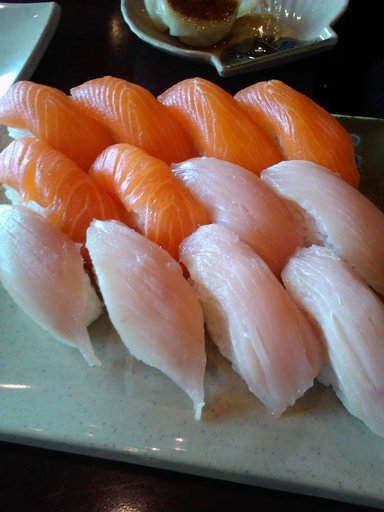

In [13]:
# Visualizar uma imagem
import random
from PIL import Image

# 1 ler todos os caminhos das imagens
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2 selecionar imagem aleatória
random_image_path = random.choice(image_path_list)

# 3 selecionar classe (nome do diretório pai)
image_class = random_image_path.parent.stem

# 4 ler img
img = Image.open(random_image_path)

print("Path: ", random_image_path)
print("Class: ", image_class)
print("Height: ", img.height)
print("Width: ", img.width)
img

Text(0.5, 1.0, 'Shape: (512, 384, 3) Class: sushi')

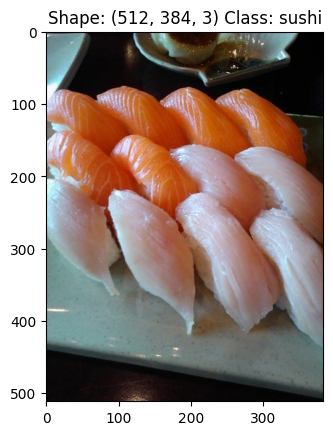

In [18]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)
plt.imshow(img_array);
plt.title(f"Shape: {img_array.shape} Class: {image_class}")

## 2 Load to Tensors

In [19]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [22]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), # redimensiona a imagem 64 x 64
    transforms.RandomHorizontalFlip(p=0.5), # aleatoriamente 50% de chances de flipar horizontalmente
    transforms.ToTensor() # transforma para um vetor do torch
])

In [31]:
def plot_transformed_images(image_paths,
                            transform,
                            n=3):
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \n Size: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) # permuta a posição dos items do array
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

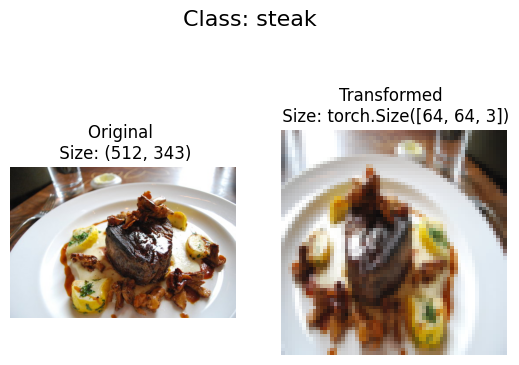

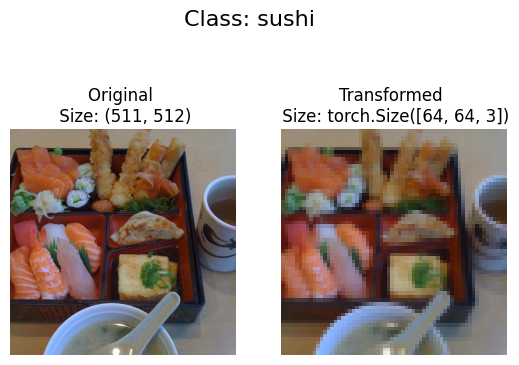

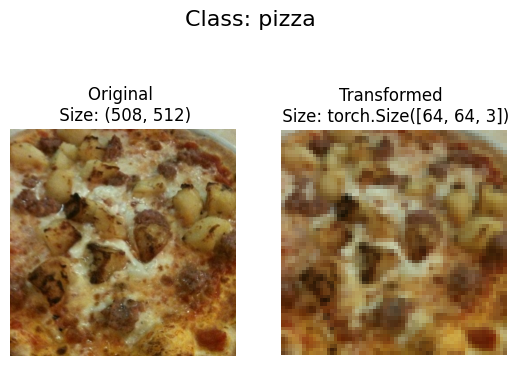

In [32]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## Opção 1: Carregar os dados com Image Folder

In [33]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [34]:
# get_class
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [36]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [39]:
len(train_data), len(test_data)

(225, 75)

In [40]:
img, label = train_data[0][0], train_data[0][1]

img.shape, img.dtype, label, type(label)

(torch.Size([3, 64, 64]), torch.float32, 0, int)

## 3 Carregar para o DataLoader

In [47]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                               batch_size=1,
                               num_workers=1,
                               shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                               batch_size=1, # 1 batch por amostra
                               num_workers=1,
                               shuffle=False)

img, label = next(iter(train_dataloader))
img.shape # [batch, channel, width, height]

torch.Size([1, 3, 64, 64])

## Opção 2: Carregar os dados com Custom Dataset

In [48]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [50]:
# função para retornar lista de classes e dicionario de classes
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Classes não encontradas na pasta {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [51]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [59]:
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir:str, transform=None) -> None:
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    #__len__ -> sobrescrever o metodo
    def __len__(self) -> int:
        return len(self.paths)

    #__getitem__ -> sobrescrever o metodo getitem
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # if transform is defined
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [54]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [60]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [61]:
len(train_data_custom) == len(train_data)

True

## 3 Carregar para o DataLoader

In [65]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [64]:
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

## 4 Criar modelo - TinyVGG

In [67]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential( # 3, 64, 64
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 10, 32, 32
        )
        self.conv_block_2 = nn.Sequential( # 10, 32, 32
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) # 10, 16, 16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, # 2560
                      out_features=output_shape) # 3
        )
    def forward(self, x):
        x = self.conv_block_1(x) # 3, 32, 32
        x = self.conv_block_2(x) # 10, 16, 16
        x = self.classifier(x)   # 3


In [70]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [71]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  --                        --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia